In [41]:
import gymnasium as gym
import math
import random
import copy
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda')

# Среда

In [3]:
env = gym.make("LunarLander-v2")

In [4]:
env.observation_space.shape[0]

8

In [5]:
env.action_space

Discrete(4)

# Обычный DQN

## Алгоритм

Создаем класс для DQN.

In [22]:
class DQN():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.05):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_state, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_action)
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def update(self, s, y):
        y_pred = self.model(torch.Tensor(s))
        loss = self.criterion(y_pred, torch.Tensor(y))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, s):
        with torch.no_grad():
            return self.model(torch.Tensor(s))

Функция для эпсилон-жадной стратегии.

In [23]:
def gen_epsilon_greedy_policy(estimator, state, epsilon, n_action):
    if random.random() < epsilon:
        return random.randint(0, n_action - 1)
    else:
        q_values = estimator.predict(state)
    return torch.argmax(q_values).item()

Функция для deep q-learning.

In [24]:
def deep_q_learning(env, estimator, n_episode, gamma=0.99, epsilon=1, update_epsilon=1/200):
    n_actions = env.action_space.n
    # Начинаем со случайного выбора действий (для исследования)
    epsilon = epsilon
    # Инициализируем переменные для хранения награды, длины эпизодов и средней награды за последние 100 эпизодов
    total_rewards = []
    avg_rewards_last_100_episodes = []
    
    for episode in tqdm(range(n_episode)):
        state, _ = env.reset()
        total_reward_episode = 0
        is_done = False
        while not is_done:
            action = gen_epsilon_greedy_policy(estimator, state, epsilon, n_actions)
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward_episode += reward

            is_done = terminated or truncated

            q_values = estimator.predict(state).tolist()
            q_values_next = estimator.predict(next_state)
            q_values[action] = reward + gamma * torch.max(q_values_next).item()
            estimator.update(state, q_values)
            state = next_state
            
        epsilon = max(epsilon - update_epsilon, 0.01)

        # Фиксируем награду для эпизода и среднюю награду за последние 100 эпизодов
        total_rewards.append(total_reward_episode)
        avg_rewards_last_100_episodes.append(np.mean(total_rewards[-100:]))
    return estimator, total_rewards, avg_rewards_last_100_episodes

## Обучение агента в среде Lunar-lander

In [25]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 64
lr = 0.001
dqn = DQN(n_state, n_action, n_hidden, lr)

In [26]:
estimator, total_rewards, avg_rewards_last_100_episodes = deep_q_learning(
    env=env, estimator=dqn, n_episode=500, gamma=0.99, epsilon=1, update_epsilon=1/200
)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:42<00:00,  3.09it/s]


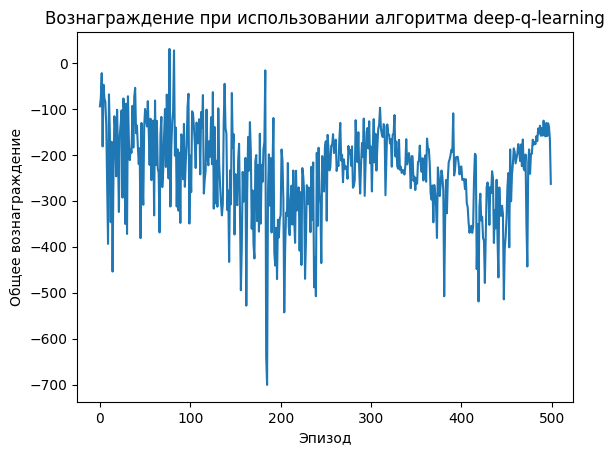

In [27]:
plt.plot(total_rewards)
plt.title('Вознаграждение при использовании алгоритма deep-q-learning')
plt.xlabel('Эпизод')
plt.ylabel('Общее вознаграждение')
plt.show()

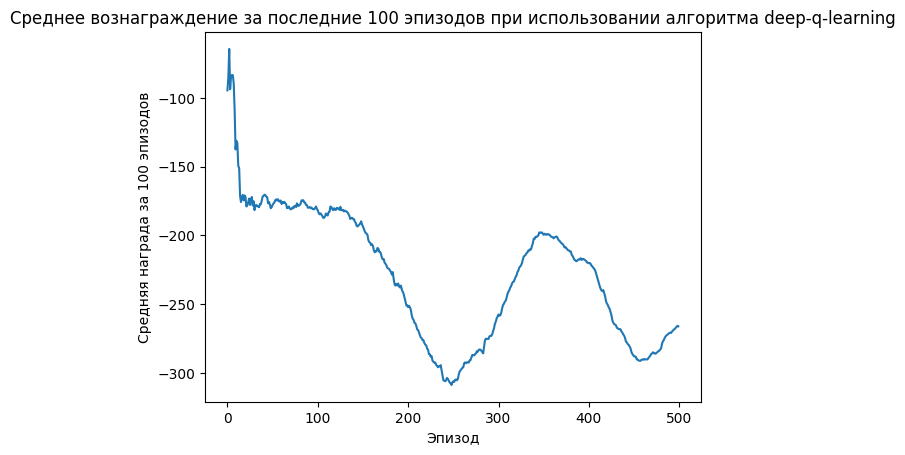

In [28]:
plt.plot(avg_rewards_last_100_episodes)
plt.title('Среднее вознаграждение за последние 100 эпизодов при использовании алгоритма deep-q-learning')
plt.xlabel('Эпизод')
plt.ylabel('Средняя награда за 100 эпизодов')
plt.show()

500 эпизодов недостаточно для обучения модели. 

# DQN с реплей буффером

## Алгоритм

Добавим в наш класс работу с буффером.

In [29]:
class DQN_replay():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.05, replay_capacity=10000):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_state, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_action)
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
        self.memory = deque([], maxlen=replay_capacity)

    def update(self, s, y):
        y_pred = self.model(torch.Tensor(s))
        loss = self.criterion(y_pred, torch.Tensor(y))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, s):
        with torch.no_grad():
            return self.model(torch.Tensor(s))

    def replay(self, replay_size, gamma):
        if len(self.memory) >= replay_size:
            replay_data = random.sample(self.memory, replay_size)
            states = []
            td_targets = []
            for state, action, next_state, reward, is_done in replay_data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if is_done:
                    q_values[action] = reward
                else:
                    q_values_next = self.predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()
                td_targets.append(q_values)
            self.update(states, td_targets)

In [30]:
def deep_q_learning_replay(env, estimator, n_episode, replay_size=128, gamma=0.99, epsilon=1, update_epsilon=1/200):
    n_actions = env.action_space.n
    # Начинаем со случайного выбора действий (для исследования)
    epsilon = epsilon
    # Инициализируем переменные для хранения награды, длины эпизодов и средней награды за последние 100 эпизодов
    total_rewards = []
    avg_rewards_last_100_episodes = []
    
    for episode in tqdm(range(n_episode)):
        state, _ = env.reset()
        total_reward_episode = 0
        is_done = False
        while not is_done:
            action = gen_epsilon_greedy_policy(estimator, state, epsilon, n_actions)
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward_episode += reward

            is_done = terminated or truncated
            estimator.memory.append((state, action, next_state, reward, is_done))
            if is_done:
                break

            estimator.replay(replay_size=replay_size, gamma=gamma)
            state = next_state
            
        epsilon = max(epsilon - update_epsilon, 0.01)

        # Фиксируем награду для эпизода и среднюю награду за последние 100 эпизодов
        total_rewards.append(total_reward_episode)
        avg_rewards_last_100_episodes.append(np.mean(total_rewards[-100:]))
    return estimator, total_rewards, avg_rewards_last_100_episodes

## Обучение агента в среде Lunar-lander

In [33]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 64
lr = 0.001
dqn_replay = DQN_replay(n_state, n_action, n_hidden, lr)

In [34]:
estimator, total_rewards, avg_rewards_last_100_episodes = deep_q_learning_replay(
    env=env, estimator=dqn_replay, replay_size=32, n_episode=500, gamma=0.99, epsilon=1, update_epsilon=1/200
)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [22:59<00:00,  2.76s/it]


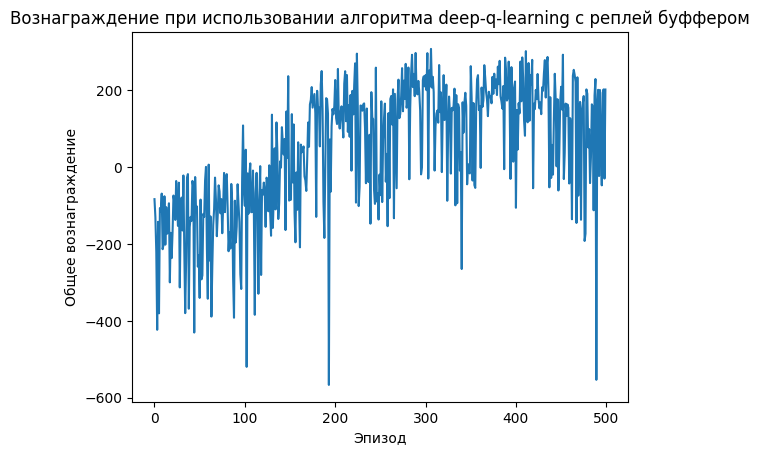

In [35]:
plt.plot(total_rewards)
plt.title('Вознаграждение при использовании алгоритма deep-q-learning с реплей буффером')
plt.xlabel('Эпизод')
plt.ylabel('Общее вознаграждение')
plt.show()

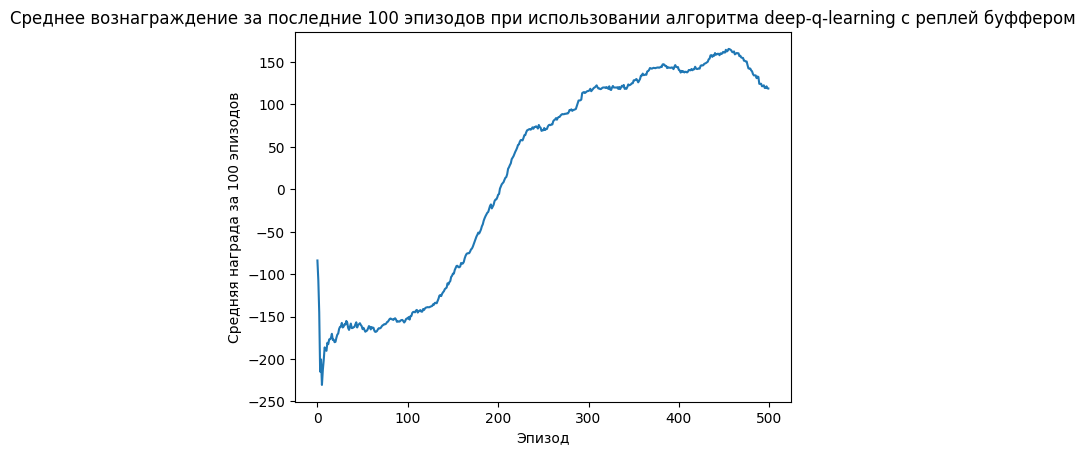

In [36]:
plt.plot(avg_rewards_last_100_episodes)
plt.title('Среднее вознаграждение за последние 100 эпизодов при использовании алгоритма deep-q-learning с реплей буффером')
plt.xlabel('Эпизод')
plt.ylabel('Средняя награда за 100 эпизодов')
plt.show()

Добавление реплей буффера заметно улучшает производительность модели. В итоге агенту хватает 500 эпизодов, чтобы научиться корректно сажать корабль.

# DQN с реплей буффером и мягким обновлением целевой сети

## Алгоритм

Добавим вторую сеть. В итоге имеем предсказательную (policy_net) и целевую (target_net) сети.

In [43]:
class DQN_replay_soft():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.05, replay_capacity=10000):
        self.criterion = torch.nn.MSELoss()
        self.policy_net = torch.nn.Sequential(
            torch.nn.Linear(n_state, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_action)
        )
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr)
        self.memory = deque([], maxlen=replay_capacity)
        self.target_net = copy.deepcopy(self.policy_net)

    def update(self, s, y):
        y_pred = self.policy_net(torch.Tensor(s))
        loss = self.criterion(y_pred, torch.Tensor(y))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    # Предсказание сети политики
    def predict(self, state):
        with torch.no_grad():
            return self.policy_net(torch.Tensor(state))

    # Предсказание целевой сети
    def target_predict(self, state):
        with torch.no_grad():
            return self.target_net(torch.Tensor(state))

    def replay(self, replay_size, gamma):
        if len(self.memory) >= replay_size:
            replay_data = random.sample(self.memory, replay_size)
            states = []
            td_targets = []
            for state, action, next_state, reward, is_done in replay_data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if is_done:
                    q_values[action] = reward
                else:
                    q_values_next = self.target_predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()
                td_targets.append(q_values)
            self.update(states, td_targets)

    # Добавим функцию для мягкого обновления весов целевой сети
    def update_weights_soft(self, tau):
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * tau + target_net_state_dict[key] * (1 - tau)
        self.target_net.load_state_dict(target_net_state_dict)

In [44]:
def deep_q_learning_replay_soft(env, estimator, n_episode, replay_size=128, tau=0.005, gamma=0.99, epsilon=1, update_epsilon=1/200):
    n_actions = env.action_space.n
    # Начинаем со случайного выбора действий (для исследования)
    epsilon = epsilon
    # Инициализируем переменные для хранения награды, длины эпизодов и средней награды за последние 100 эпизодов
    total_rewards = []
    avg_rewards_last_100_episodes = []
    
    for episode in tqdm(range(n_episode)):
        state, _ = env.reset()
        total_reward_episode = 0
        is_done = False
        while not is_done:
            action = gen_epsilon_greedy_policy(estimator, state, epsilon, n_actions)
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward_episode += reward

            is_done = terminated or truncated
            estimator.memory.append((state, action, next_state, reward, is_done))
            if is_done:
                break

            estimator.replay(replay_size=replay_size, gamma=gamma)
            estimator.update_weights_soft(tau=tau)
            state = next_state
            
        epsilon = max(epsilon - update_epsilon, 0.01)

        # Фиксируем награду для эпизода и среднюю награду за последние 100 эпизодов
        total_rewards.append(total_reward_episode)
        avg_rewards_last_100_episodes.append(np.mean(total_rewards[-100:]))
    return estimator, total_rewards, avg_rewards_last_100_episodes

## Обучение агента в среде Lunar-lander

In [45]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 64
lr = 0.001
dqn_replay_soft = DQN_replay_soft(n_state, n_action, n_hidden, lr)

In [46]:
estimator, total_rewards, avg_rewards_last_100_episodes = deep_q_learning_replay_soft(
    env=env, estimator=dqn_replay_soft, n_episode=500, replay_size=32, tau=0.005, gamma=0.99, epsilon=1, update_epsilon=1/200
)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [24:36<00:00,  2.95s/it]


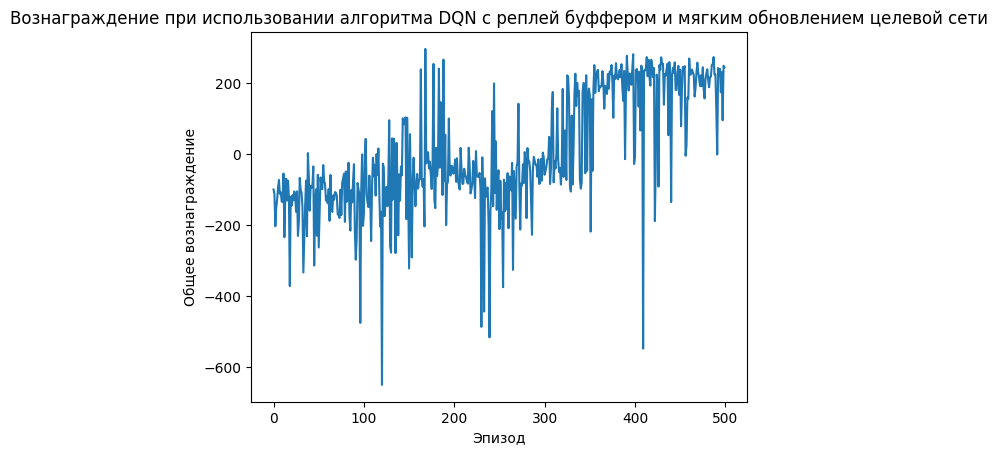

In [47]:
plt.plot(total_rewards)
plt.title('Вознаграждение при использовании алгоритма DQN с реплей буффером и мягким обновлением целевой сети')
plt.xlabel('Эпизод')
plt.ylabel('Общее вознаграждение')
plt.show()

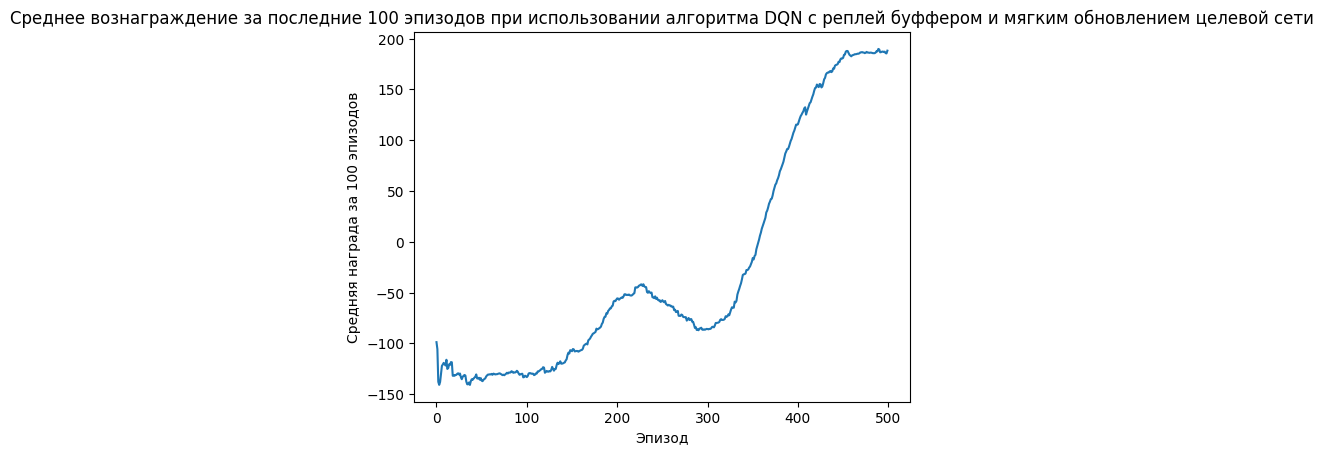

In [48]:
plt.plot(avg_rewards_last_100_episodes)
plt.title('Среднее вознаграждение за последние 100 эпизодов при использовании алгоритма DQN с реплей буффером и мягким обновлением целевой сети')
plt.xlabel('Эпизод')
plt.ylabel('Средняя награда за 100 эпизодов')
plt.show()